## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from helpers import *
from architecture.AutoEncoder import *

In [2]:
torch.manual_seed(110)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 64
batch_size = 1
examples = []
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [5]:
root = 'real_and_fake_face/train'
train_data = create_dataset(root, transformation)
data_loader = produce_loader(train_data, batch_size)

[586, 1095, 1443, 825, 1292, 1108, 715, 423, 2370]


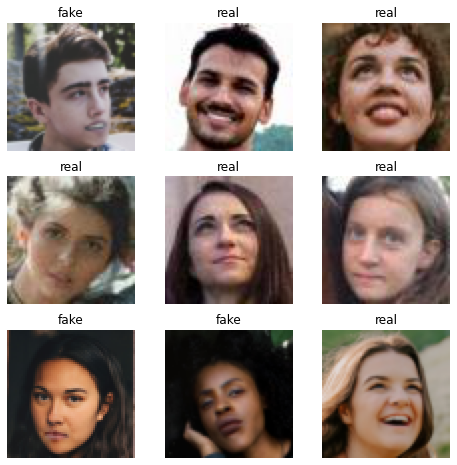

In [6]:
visualize_data(train_data)

In [7]:
def generate_epsilon_image(device, image, epsilon=0.03):
    
    # Generate noise matrix, with same shape as image,
    # and random values in [- epsilon, epsilon]
    img_rows = image.shape[-2]
    img_cols = image.shape[-1]
    epsilon_mat = (torch.rand(3, img_cols, img_rows, device=device) - 0.5) * 2 * epsilon
    
    # Create the attack image by adjusting each pixel of the input image
    eps_image = image + epsilon_mat
    
    # Clipping eps_image to maintain pixel values into the [0, 1] range
    eps_image = eps_image.float()
    eps_image = torch.clamp(eps_image, 0, 1)
    
    # Return
    return eps_image

In [8]:
for image, label in data_loader:
    if label.item()==1:
        image = image.to(device)
        eps_image = generate_epsilon_image(device, image)
        eps_image = torch.squeeze(eps_image)
        eps_image = eps_image.cpu().detach().numpy()
        examples.append(eps_image)

In [8]:
for image, label in data_loader:
    if label.item()==0:
        image = image.to(device)
        eps_image = generate_epsilon_image(device, image)
        eps_image = torch.squeeze(eps_image)
        eps_image = eps_image.cpu().detach().numpy()
        examples.append(eps_image)

In [9]:
def see_epsilon_images(dataset, figsize=(12,12), axes=5):
    indices = []
    cols, rows = axes, axes
    figure = plt.figure(figsize=figsize)
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        indices.append(sample_idx)
        img = dataset[sample_idx]
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(img)
    print(indices)
    indices = []
    plt.show()

[22, 695, 480, 78, 719, 374, 542, 620, 690, 399, 41, 750, 247, 243, 227, 653, 586, 211, 515, 429, 603, 652, 721, 704, 8]


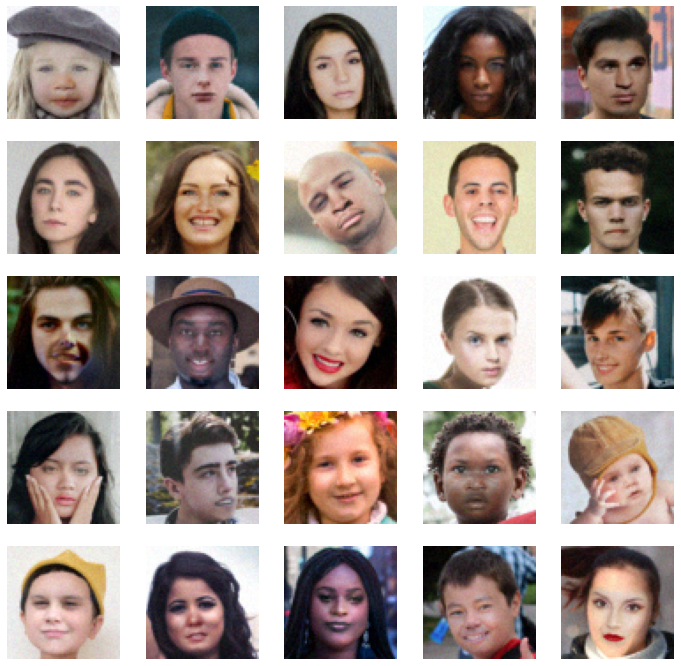

In [10]:
see_epsilon_images(examples)

In [11]:
counter = 0
for item in examples:
    item = item.swapaxes(0,1)
    item = item.swapaxes(1,2)
    plt.imsave(f'./real_and_fake_face/train/fake/epsilon_image{counter}.jpg', item)
    counter += 1